# Survey Forensics: Identifying Near Duplicate Responses

by [Andrew Wheeler](mailto:apwheele@gmail.com)

For background on the goals of identifying *near* duplicate survey responses, check out:

 - [Reluctant Criminologists EDA of their own survey](https://reluctantcriminologists.com/blog-posts/%5B8%5D/dup-series/duplicates) (RC from here on)
 - [Kuriakose & Robbins (2016) *Don't get duped* paper](http://www.mdhrobbins.net/uploads/6/2/8/0/62807029/kuriakose___robbins_-_duplicates_in_survey_data.pdf) (KR from here on)
 - Pews critique of the [KR paper](https://www.pewresearch.org/methods/2016/02/23/evaluating-a-new-proposal-for-detecting-data-falsification-in-surveys/)

As RC show, real survey data will have more duplicates simply by chance than KR paper (which has a simple rule of 85% duplicates are problematic). I make two advances here:

 - I analyze the distribution *of all* pairwise comparisons
 - I use a false discovery rate correction to correct for the multiple comparisons problem
 
I show here with simulations you can make data that will have (many) more near duplicates than 85% by the marginal distribution of the responses, e.g. if you have a bunch of rare outcomes (for example, this will happen in surveys of high risk deviance in a general population survey, so the high risk behaviors are rare).

Only analyzing the max duplicate pair per observation is unnecessary and generates a red herring discussion of using extreme value distributions to analyze the results. This results in an [extreme value fallacy](http://blog.thegrandlocus.com/2014/04/june-babies-and-bioinformatics) by selection. Here I show beta-binomial or a normal based approximation for analyzing *the entire* pairwise distributions of matches is fine, and avoids all those problems.

I end by analyzing a survey of real responses for Raleigh. I identify a small set of duplicate pairs, but show these are likely due to "run responses" -- people answering the same response for the subset of questions. I find 3 pairs of near duplicates that are potentially not explained by this though, and so do appear on their face suspicious.

In [1]:
# Set up functions, an environment with numpy/pandas/scipy/networkx/statsmodels should work
import comp_funcs as comp # my functions
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests as fdr

np.random.seed(10)

## Sim 1: Replication KR

My function `comp.sim_data`, generates a series of responses given the marginal distributions. So here generates 100 Bernoulli 50% responses (a bunch of 0's and 1's). This is a replication of the base KR simulation.

The function `comp.compare` generates counts of all pairwise matches. So with 1000 survey responses, it will generate 1000 choose 2 (or `(1000*999)/2`) pairwise comparisons. I then plot the distribution of those matches, with a fitted beta-binomial (via methods of moments matching) curve superimposed on the histogram.

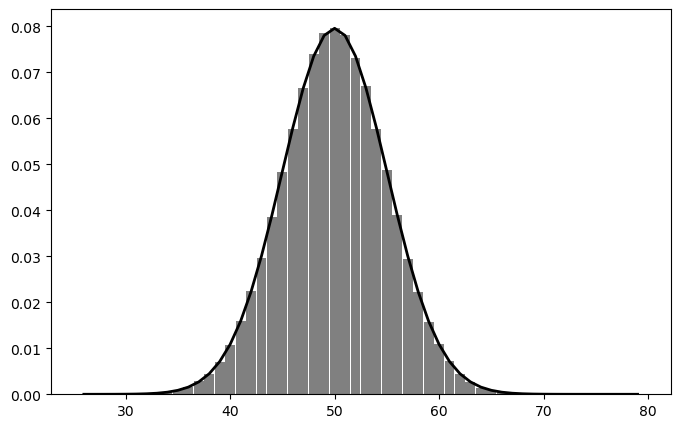

In [2]:
# replicating original KR sim
n = 1000
v = 100
props = [[0.5,0.5]]*v
sd = comp.sim_data(n,props)

co = comp.compare(sd)    # getting ALL PAIRWISE MATCHES
bm = comp.bb_mom(co,v)   # beta-binomial fit
comp.fit_plot(co,bm,v)   # can see the fit is excellent

We can now use this distribution to identify outliers -- numbers of matched pairs that are outlying compared to the rest of the distribution. Because we have so many comparisons though, I correct for multiple comparisons using a method that allows for the p-values to be correlated. In the end, there is one outlier pair (not at 85%). So this is 1 false positive, since this is random data.

In [3]:
# false discovery rate correction
pvals = 1 - bm.cdf(co)
print(f'Minimum p-value {pvals.min()}')           # can see some very low p-vals for pairs
rej, uvals, cS, cB = fdr(pvals,method='fdr_bh')
print(f'Minimum u-value (adjusted p-value) {uvals.min()}') # 1 sneaks in at under 0.05 (default alpha in fdr function)
print(f'Total outliers: {rej.sum()}')             # but when correcting no outlying, what you would expect

Minimum p-value 9.023103353378303e-08
Minimum u-value (adjusted p-value) 0.045070401250124625
Total outliers: 1


# Sim 2: More Duplicates

You can make a distribution have more duplicates than 85% by chance two ways. The one I show here is to have rarer response categories. The other is to have the responses correlated with one another. The latter happens in real data -- but I am lazy and just show how with massed questions you can generate more duplicate matches simply by chance.

This simulation shows that the questions all have one response with mass around 90%. You can get duplicate pairs above 90% matched across all 100 variables just by chance fairly easily.

My code I have some checks to fall back to a normal based approximation if the beta-binomial doesn't make sense (when the data has too low of variance). Open to suggestions here for a good default (some type of over-dispersed binomial).

## logic of how more mass in particular categories results in more matches

So imagine a question in which there are three possible responses, `{A,B,C}`, and their distribution is `[0.7, 0.2, 0.1]`. Imagine you made a table of whether two individuals matched on the same response. That crosstab would look like:

      |  A    |  B    |   C 
    --------------------------
    A | 0.7^2 |       |
    B |       | 0.2^2 |
    C |       |       | 0.1^2

I have only filled in the diagonal, as those are what matters. So the probability that if we take two random people in the population, they both responded with A is `0.7^2 = 49%`. Because we are looking at *any* match, instead of matches on just a particular response, we do that same estimate for each category. So we sum up those match probabilities on the diagonal -- which is just the sum of the marginal response distribution squared.

So for this example, the probability that two random people match is `0.7^2 + 0.2^2 + 0.1^2 = 0.54`. Note that KR say that surveys with more than 2 response categories are less likely to have higher match probabilities -- but this is not true as stated. This is only true if the marginal responses are spread out evenly. So imagine a 5 scale likert question, in which the probabilities are `[0.96,0.01,0.01,0.01,0.01]`. The probability of matching on this question is over 92%.

The expected number of matches for all pairwise comparisons is easy to estimate just based on the marginal distribution of the responses (it will only be off slightly due to finite population). The variance of those expected matches is the issue, which depends on the intra-correlation of questions as well.

100
The hypothetical mean match probs are 75.56420400000003
Mean number of matches, compare to theoretical 75.53974374374374
Max number of matches in the sample 92
Underdispersed, returning normal approximation


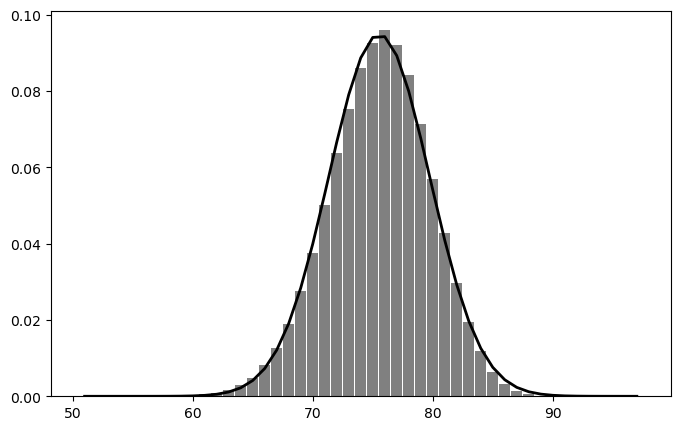

In [4]:
# sim with more rare outcomes
# this generates questions that can be 0/1, 0 to 4, or 0 to 9
# each question though has a Q that has ~90% for one category
pl = [np.array([0.9,0.1]),
      np.array([75,4,3,2,1]),
      np.array([200,20] + [3]*8)]

pl = [p/p.sum() for p in pl]

vary_probs = []

print(v)
for i in range(v):
    nc = np.random.choice(len(pl))
    vary_probs.append(pl[nc])

sd2 = comp.sim_data(n,vary_probs)

# This is the hypothetical *mean* of the number of matches
# across all pairwise comparisons
mp = comp.match_probs(sd2)
print(f'The hypothetical mean match probs are {sum(mp)}')

co2 = comp.compare(sd2)    # getting all pairwise matches
print(f'Mean number of matches, compare to theoretical {co2.mean()}')
print(f'Max number of matches in the sample {co2.max()}')

bm2 = comp.bb_mom(co2,v)   # ends up being normal fit
comp.fit_plot(co2,bm2,v)   # decent fit

But, when again doing the false discovery rate correction, we find no outliers. This method takes the data as it is, it does not select arbitrary thresholds for what counts as a match.

In [5]:
# false discovery rate correction
pvals2 = 1 - bm2.cdf(co2)
rej2, uvals2, cS, cB = fdr(pvals2,method='fdr_bh')
print(f'Min uval {uvals2.min()}')
print(f'Total outliers: {rej2.sum()}')

Min uval 0.8354683060240385
Total outliers: 0


# Sim 3: Showing Some Manipulated Data

Here I take a set of observations, then just randomly change their values. So copy + fudge a set of values. This is presumably how real 'near duplicates' happen when the survey takers are malicious and copy data, but just change a few random values.

Should be 96 matched
[96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96
 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96
 96 96]
Max number of matches 96
Underdispersed, returning normal approximation


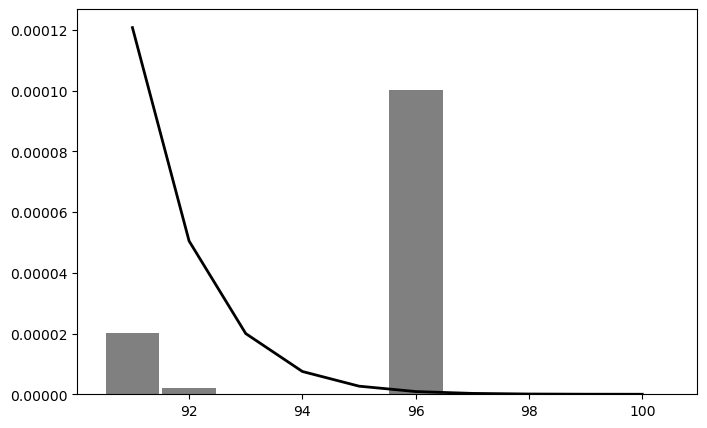

In [6]:
n_manip = 50
k_manip = 4

subcopy = sd2[0:n_manip,].copy()

# For each of these, I manipulate
# k variables, randomly permutate
# to one of the other values
rand_cols = np.random.choice(sd2.shape[1],size=k_manip)

for r in range(subcopy.shape[0]):
    for c in rand_cols:
        # get the values
        cvals = np.unique(sd2[:,c])
        # left over not in that set
        lval = set(cvals) - set([subcopy[r,c]])
        # randomly selecting one of those
        lsel = np.random.choice(list(lval))
        # replace val
        subcopy[r,c] = lsel

# To show this is correct, should all be v-k_manip
print(f'Should be {v - k_manip} matched')
print((subcopy == sd2[0:n_manip,]).sum(axis=1))

# Now insert at end
sd3 = sd2.copy()
sd3[-n_manip:,] = subcopy

co3 = comp.compare(sd3)       # getting all pairwise matches
print(f'Max number of matches {co3.max()}')
bm3 = comp.bb_mom(co3,v)      # normal fit
comp.fit_plot(co3,bm3,v,10)   # focusing on tails, easier to see outliers

In [7]:
# false discovery rate correction
pvals3 = 1 - bm3.cdf(co3)
rej3, uvals3, cS, cB = fdr(pvals3,method='fdr_bh')
print(f'Total outliers: {rej3.sum()}')

Total outliers: 50


Note that the power to uncover outliers in this technique is *almost* entirely based on `k_manip` here (the number of columns manipulated). If someone manipulated 10 columns, this technique would not uncover them in this set of data.

This fact I am afraid is the nature of the task -- if you have data in which responses have a mass at particular values, duplicates will be normal. In this scenarios it is much more difficult to identify intentionally manipulated data. Fortunately people who are smart enough to write code to manipulate data in a systematic fashion like this can make money as a data scientist -- so it is mostly unnecessary. 

But people who are stupid and lazy (copy-paste, manipulate a few columns) will be caught using this technique. Or in-advertant duplication with people retaking surveys (especially for web based surveys).

# Analyzing Real Data

This is a real set of survey data from Raleigh. It used to be up at [this link](https://data-ral.opendata.arcgis.com/datasets/community-survey-fy18/explore) (that is dead now, I don't know). I put a more recent round of the same survey (2020) in this repo that has the instrument, see `2020-community-survey-results-report.pdf`.

Here I am lazy and just take the first set of questions that are easy in a block to analyze.

Total number of variables 64
Max number of matches 62


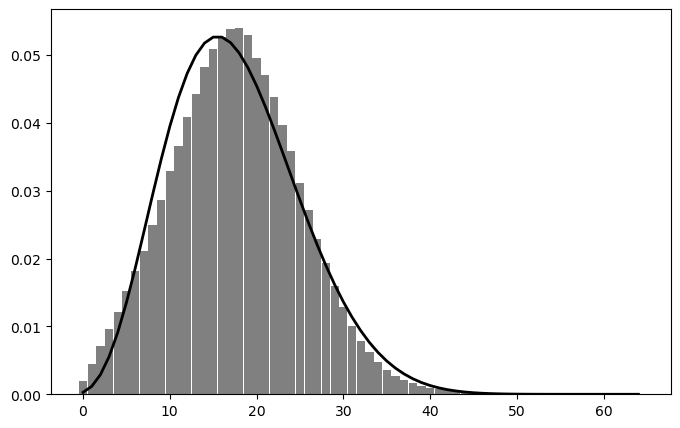

In [8]:
surv = pd.read_csv('Ral18_Survey.csv')
vars_sel = list(surv)[4:68]
sd4 = surv[vars_sel].fillna(9).astype(int).to_numpy().clip(1,9)
v = len(vars_sel)
print(f'Total number of variables {v}')

co4 = comp.compare(sd4)    # getting all pairwise matches
print(f'Max number of matches {co4.max()}')
bm4 = comp.bb_mom(co4,v)   # beta-binomial fit
comp.fit_plot(co4,bm4,v)   # can see the fit is too left skewed

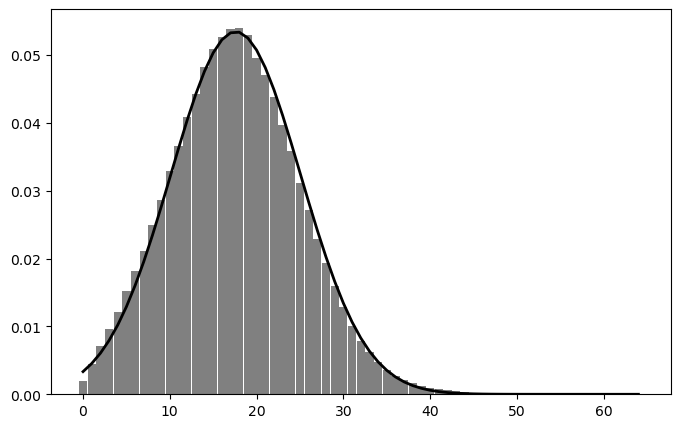

In [9]:
# Because of bad fit, I am trying the normal approximation
bm4 = comp.norm(co4.mean(),co4.std()) 
comp.fit_plot(co4,bm4,v) # much better

In [10]:
# false discovery rate correction
pvals4 = 1 - bm4.cdf(co4)
rej4, uvals4, cS, cB = fdr(pvals4,method='fdr_by')
print(f'Total outliers: {rej4.sum()}') # we have a few!

# This gives 25 outliers
# can see the number of matches that are flagged
co4[rej4]

Total outliers: 25


array([56, 58, 56, 56, 56, 62, 57, 57, 60, 56, 58, 56, 62, 58, 60, 60, 56,
       56, 56, 56, 58, 58, 58, 56, 62])

All that work, and it ends up being matches with over 85% duplicates (56/64 ~ 88%) are flagged anyway!

Lets do some digging into these observations.

In [11]:
# Check out the ID pairs
idp = comp.ret_ids(sd4.shape[0],rej4)
print(idp)

# Lets see some patterns in these responses
uid = np.unique(idp)
outliers = sd4[uid,:]
outliers

[[194 552]
 [194 830]
 [209 822]
 [209 878]
 [363 830]
 [445 815]
 [452 526]
 [452 721]
 [452 758]
 [452 822]
 [452 965]
 [464 732]
 [491 712]
 [526 758]
 [526 965]
 [552 819]
 [552 844]
 [721 758]
 [721 965]
 [758 785]
 [758 822]
 [758 965]
 [785 822]
 [822 965]
 [931 952]]


array([[5, 5, 5, ..., 5, 5, 5],
       [4, 4, 5, ..., 4, 4, 4],
       [5, 5, 5, ..., 5, 5, 5],
       ...,
       [2, 3, 3, ..., 9, 1, 3],
       [2, 3, 3, ..., 9, 1, 3],
       [4, 4, 4, ..., 4, 4, 4]])

Although the table is cut-off, you can see a potential hint as to why we have 25 outlier match pairs here -- runs of responses consistently 5's or 4's throughout the survey.

Note that the way I do the analysis, I don't just limit to the "max" matched group. If you had a case where someone copy-pasted *from a single row*, and then changed a few of the columns, it will result in a single focal observation having multiple near matches. This is to be expected -- and is a reason why you should analyze all pairs, not just the max duplicate per ID.

I have a helper function to identify the connected components (so groups of responses that have similar matches), where we can see what is going on within those groups.

In [12]:
sub_comp = comp.conn_comp(idp)
print('These are the groupings of IDs with similar duplicates')
print(sub_comp) # we end up having 6 components

for i,c in enumerate(sub_comp):
    print(f'\nComponent {i}')
    print(sd4[c,:])

These are the groupings of IDs with similar duplicates
[[194, 552, 363, 844, 819, 830], [452, 965, 878, 526, 209, 785, 721, 822, 758], [445, 815], [464, 732], [712, 491], [952, 931]]

Component 0
[[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 5 5 5 5 2 1 5 5 5 5 5 5 5 5
  5 5 5 5 1 2 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 5 5 5 5 9 9 5 5 5 5 5 5 5 5
  5 5 5 5 9 9 9 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 1 5 5 5 5 5 5 5 6 4 5 5 5 5 5 5 5
  5 5 5 5 1 8 6 2 1 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 4 5 5 5 5 3 5 5 5 5 5 5 5 9 5 4 5 6 9 4 5 5 5 5 5 1 9 5 5 5 5 5 5 5 5
  5 5 5 5 9 9 9 4 4 4 5 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 5 5 5 5 5 5 9 9 5 5 5 5 5 5 5 5
  5 5 5 5 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 1 5 5 5 5 5 5 1 5 5 5 5 5 5 5 5 5
  5 5 5 5 1 4 5 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]]

Comp

You can see that for each set of duplicate pairs of responses, we have:

 - Comp 0: runs of just responding 5's
 - Comp 1: runs of just responding 4's
 - Comp 2: missing data
 - Comp 3: runs of 4s, but with a few more variables varied
 - Comp 4 & 5: More varied -- these look to me more legitimate potential duplicate survey responses

Components 0/1/2 IMO are easily explained by potential running the same responses to the survey (I would be tempted too -- who answers these surveys with so many questions?). Components 3/4/5 are tougher to attribute this though, and appear to be potentially duplicates. Below you can check out the full response set for each and decide for yourself if they are problematic.

In [13]:
# Comp 3 -- different districts/zips, so maybe is just random chance
surv.iloc[sub_comp[3],]

ID DISTRICT  BLOCK_LAT  BLOCK_LON  \
464  823        C  35.730999 -78.537003   
732  932        E  35.897999 -78.805000   

     Overall_quality_of_life_in_Raleigh__1_01  \
464                                         4   
732                                         4   

     Overall_quality_of_life_in_your_neighborhood__1_02  \
464                                                  4    
732                                                  4    

     Raleigh_as_a_place_to_live__1_03  \
464                                 4   
732                                 4   

     Raleigh_as_a_place_to_raise_children__1_04  \
464                                           4   
732                                           4   

     Raleigh_as_a_place_to_retire__1_05  Raleigh_as_a_place_to_work__1_06  \
464                                   4                                 4   
732                                   4                                 4   

     ...  \
464  ...   
732  ...   

     Which_of_the_following_is_the_highest_level_of_education_you_have_completed___31  \
464                                                  2                                  
732                                                  2                                  

     Highest_Education__31  \
464                     No   
732                     No   

     Would_you_say_your_total_annual_household_income_is___32  \
464                                                  1          
732                                                  2          

     Household_Income__32  What_is_your_HOME_zip_code___33  \
464                  Male                                7   
732                Female                                7   

                                     Highest_Education  \
464  Graduate/Professional degree (Master's, PhD, J...   
732  Graduate/Professional degree (Master's, PhD, J...   

     Your_total_annual_household_income_is_  Annual_Household_Income  \
464                                       2        $30,000 - $59,999   
732                                       4      $100,000 - $149,999   

     __What_is_your_HOME_zip_code_  FID  
464                        27610.0  465  
732                        27617.0  733  

[2 rows x 196 columns]

In [14]:
# Comp 4 -- these look pretty suspicious, closish together IDs as well
surv.iloc[sub_comp[4],]

ID DISTRICT  BLOCK_LAT  BLOCK_LON  \
712  899        B     35.924 -78.582001   
491  860        B     35.924 -78.582001   

     Overall_quality_of_life_in_Raleigh__1_01  \
712                                         4   
491                                         4   

     Overall_quality_of_life_in_your_neighborhood__1_02  \
712                                                  4    
491                                                  4    

     Raleigh_as_a_place_to_live__1_03  \
712                                 4   
491                                 4   

     Raleigh_as_a_place_to_raise_children__1_04  \
712                                           4   
491                                           4   

     Raleigh_as_a_place_to_retire__1_05  Raleigh_as_a_place_to_work__1_06  \
712                                   9                                 4   
491                                   9                                 4   

     ...  \
712  ...   
491  ...   

     Which_of_the_following_is_the_highest_level_of_education_you_have_completed___31  \
712                                                  2                                  
491                                                  2                                  

     Highest_Education__31  \
712                     No   
491                     No   

     Would_you_say_your_total_annual_household_income_is___32  \
712                                                  1          
491                                                  1          

     Household_Income__32  What_is_your_HOME_zip_code___33  Highest_Education  \
712                  Male                                6  Bachelor's degree   
491                  Male                                6  Bachelor's degree   

     Your_total_annual_household_income_is_  Annual_Household_Income  \
712                                       5         $150,000 or More   
491                                       5         $150,000 or More   

     __What_is_your_HOME_zip_code_  FID  
712                        27614.0  713  
491                        27614.0  492  

[2 rows x 196 columns]

In [15]:
# Comp 5 - female/male (so maybe same household?)
surv.iloc[sub_comp[5],]

ID DISTRICT  BLOCK_LAT  BLOCK_LON  \
952  900        D  35.751999    -78.681   
931  829        D  35.751999    -78.681   

     Overall_quality_of_life_in_Raleigh__1_01  \
952                                         2   
931                                         2   

     Overall_quality_of_life_in_your_neighborhood__1_02  \
952                                                  3    
931                                                  3    

     Raleigh_as_a_place_to_live__1_03  \
952                                 3   
931                                 3   

     Raleigh_as_a_place_to_raise_children__1_04  \
952                                           2   
931                                           2   

     Raleigh_as_a_place_to_retire__1_05  Raleigh_as_a_place_to_work__1_06  \
952                                   1                                 1   
931                                   1                                 1   

     ...  \
952  ...   
931  ...   

     Which_of_the_following_is_the_highest_level_of_education_you_have_completed___31  \
952                                                  9                                  
931                                                  2                                  

     Highest_Education__31  \
952                    NaN   
931                     No   

     Would_you_say_your_total_annual_household_income_is___32  \
952                                                  2          
931                                                  1          

     Household_Income__32  What_is_your_HOME_zip_code___33  \
952                Female                                4   
931                  Male                                4   

            Highest_Education  Your_total_annual_household_income_is_  \
952  Some college (no degree)                                       1   
931  Some college (no degree)                                       1   

     Annual_Household_Income  __What_is_your_HOME_zip_code_  FID  
952            Under $30,000                        27603.0  953  
931            Under $30,000                        27603.0  932  

[2 rows x 196 columns]

## Other Notes

In the case the responses were independent, the number of matches would be generated via a [Poisson-Binomial distribution](https://en.wikipedia.org/wiki/Poisson_binomial_distribution). (If you are for the logic let me know, but check out the `comp.match_probs` for the independent probability of a match based on the marginal distribution of responses.) In my simulations this distribution is the "true" underlying distribution. In real surveys though, questions have intra-correlations (e.g. how you answer on one question is correlated with another question), making the resulting distribution of matches over-dispersed.

It may be other distributions are "better out of the box" than my suggested normal or beta-binomial. Or there may be reasonable leave-k-out non-parametric approaches. Let me know if you have suggestions!

Finally, there are ultimately other approaches to identifying near matches. I would suggest for further study those interested:

 - [Jacobb and Levitt (2003) *Rotten Apples*](https://pricetheory.uchicago.edu/levitt/Papers/JacobLevitt2003.pdf) paper identifies cheating in blocks of questions.
 - If incorporating continuous valued responses, you may look into [probabilistic record linkage](https://imai.fas.harvard.edu/research/linkage.html).
 - This recent post by Urban, [*How to Tackle Fraudulent Survey Responses*](https://urban-institute.medium.com/how-to-tackle-fraudulent-survey-responses-4427f271a194). This focuses on web-based surveys, so you can look at IP addresses for example or timestamps in a close run
 - The recent DataColada [examples of manipulated data](http://datacolada.org/109) focus on re-ordering data and changing treatment status -- that would not have been uncovered in these examples. This would be if someone duplicated responses to get a larger sample size.
 
Note the Raleigh survey is paper based -- so presumably people retaking web-based is not an explanation for the responses I saw. They did do multiple rounds, so maybe someone responded multiple times and by accident they counted them again (component 4 here could be explained that way).